0. Install and import libraries

In [ ]:
## install libraries

!pip install transformers
!pip install sentencepiece

In [ ]:
import pandas as pd
import numpy as np
import random
import json
import regex as re

import matplotlib.pyplot as plt
import os
import sentencepiece
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from transformers import AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import XLMRobertaConfig, XLMRobertaModel, XLMRobertaTokenizer

torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")



# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#Enrich training and test data with NER Info

Enriching train data with NER info

In [ ]:
import pandas as pd
training_data = pd.read_csv('training_data.csv')
training_data = training_data.dropna()
training_data

,text1,text2,lang1,lang2,Geography,Entities,Time,Narrative,Overall,Style,Tone
0,ORG: Zomato Buys ORG: Uber ' s Food Delivery B...,MISC: Indian Online Food Delivery Market to Hi...,en,en,1.000000,2.333333,2.666667,1.666667,2.000000,1.666667,1.666667
1,ORG: Wiesenthal Center Calls for ORG: FBI Task...,ORG: Jewish Groups React to MISC: Monsey ORG: ...,en,en,1.250000,1.750000,1.250000,1.750000,2.000000,1.000000,1.250000
2,Big cut on import duty on crude and refined pa...,LOC: Delhi weather update: Delhiites shiver at...,en,en,3.000000,4.000000,1.333333,4.000000,3.666667,1.333333,1.333333
3,The biggest business con of 2019: fleecing wor...,The left’s constant victimhood olympics is a g...,en,en,2.333333,3.666667,1.333333,3.666667,3.333333,1.333333,1.333333
4,MISC: The Compatriots : The Brutal and Chaotic...,ORG: Amazon. com.Enter the characters you see ...,en,en,1.000000,4.000000,4.000000,1.000000,4.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2485,Cena ropy WTI. Kilka słów o ogonie i jego psi...,Gdzie można otworzyć konto maklerskie? Rachun...,pl,pl,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,3.000000
2486,El jefe de ORG: Grab dice que obtuvo un reemb...,I passeggeri pagheranno P10 in più per la tass...,es,it,1.000000,3.000000,1.333333,3.000000,3.000000,1.666667,1.333333
2487,Offenbach: Polizei findet Mann hilflos auf St...,"ORG: BMW gets smashed by train, driver surviv...",de,en,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,3.000000
2488,Oltre 13 milioni di palestinesi nel mondo ent...,La popolazione mondiale palestinese è di 13 mi...,it,it,1.000000,1.333333,1.333333,1.666667,1.000000,2.666667,1.000000


In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863 entries, 0 to 2862
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text1      2863 non-null   object 
 1   text2      2863 non-null   object 
 2   lang1      2863 non-null   object 
 3   lang2      2863 non-null   object 
 4   Geography  2863 non-null   float64
 5   Entities   2863 non-null   float64
 6   Time       2863 non-null   float64
 7   Narrative  2863 non-null   float64
 8   Overall    2863 non-null   float64
 9   Style      2863 non-null   float64
 10  Tone       2863 non-null   float64
dtypes: float64(7), object(4)
memory usage: 246.2+ KB


We are using Babelscape/wikineural-multilingual-ner and this Multingual NER  supports (de, en, es, fr, it, nl, pl, pt, ru)

In [ ]:
training_data['lang1'].unique()
#The languages tr, ar and zh is not supported by this ner

In [ ]:
#Filtering out articles in the languages 'tr', 'ar', 'zh'
exclude_values = ['tr', 'ar', 'zh']
filtered_df = training_data[~training_data['lang1'].isin(exclude_values) & ~training_data['lang2'].isin(exclude_values)]
filtered_df['lang1'].unique()

array(['en', 'de', 'es', 'pl', 'fr', 'it', 'ru'], dtype=object)

In [ ]:
#LOading NER model
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

ner_tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
ner_model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")



tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

In [ ]:
#using NER model to add named entity labels in our dataset
def insert_entity_labels(text):
    nlp = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, grouped_entities=True)

    ner_results = nlp(text)
    # print(ner_results)
    # Sort entities by their start position in descending order
    entities = sorted(ner_results, key=lambda x: x['start'], reverse=True)

    # Insert entity labels into the text
    for entity in entities:
        entity_label = f"{entity['entity_group']}: {entity['word']}"
        text = text[:entity['start']] + entity_label + text[entity['end']:]

    return text

In [ ]:
filtered_df['text1'] = filtered_df['text1'].apply(insert_entity_labels)
filtered_df['text2'] = filtered_df['text2'].apply(insert_entity_labels)
#Enriched training dataset
filtered_df['text1']

<ipython-input-44-f6887745e4a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text1'] = filtered_df['text1'].apply(insert_entity_labels)
<ipython-input-44-f6887745e4a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text2'] = filtered_df['text2'].apply(insert_entity_labels)


,text1
0,ORG: Zomato Buys ORG: Uber ' s Food Delivery B...
1,ORG: Wiesenthal Center Calls for ORG: FBI Task...
2,Big cut on import duty on crude and refined pa...
3,The biggest business con of 2019: fleecing wor...
4,MISC: The Compatriots : The Brutal and Chaotic...
...,...
2855,Cena ropy WTI. Kilka słów o ogonie i jego psi...
2856,El jefe de ORG: Grab dice que obtuvo un reemb...
2857,Offenbach: Polizei findet Mann hilflos auf St...
2858,Oltre 13 milioni di palestinesi nel mondo ent...


In [ ]:
filtered_df.to_csv('enriched_training_data.csv', index=False)

In [ ]:
training_data['lang1'].value_counts()

,count
lang1,
en,1093
de,544
es,472
pl,203
fr,77
it,57
ru,44


Enriching Test Data with NER info

In [ ]:
test_data = pd.read_csv('testing_set.csv')
test_data.info()



In [ ]:
#Enriching test dataset with named enity labels in the same way as training data
print(test_data['lang1'].unique())
exclude_values = ['tr', 'ar', 'zh']
filtered_test_df = test_data[~test_data['lang1'].isin(exclude_values) & ~test_data['lang2'].isin(exclude_values)]
filtered_test_df['lang1'].unique()

In [ ]:
filtered_test_df['text1'] = filtered_test_df['text1'].apply(insert_entity_labels)
filtered_test_df['text2'] = filtered_test_df['text2'].apply(insert_entity_labels)

#enriched testing dataset
filtered_test_df['text1']



In [ ]:
filtered_test_df.to_csv('enriched_test_data.csv', index=False)

split the enriched training data into train and validation set

In [ ]:
training_data = pd.read_csv('enriched_training_data.csv')

train, dev = train_test_split(training_data, test_size=0.1, random_state = 42)

## XLM ROberta model formation same as previous experiments

In [ ]:

## set parameters
max_len = 512
batch_size = 5
lr = 5e-6
weight_decay = 1e-4
num_epochs = 8


In [ ]:
def get_data_loader(data, batch_size_flg = True):
  tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
  input_ids, attention_masks, labels = [], [], []
  for idx, row in data.iterrows():
      text1, text2 = row['text1'], row['text2']
      encode_dict = tokenizer(text1,text2,
                                  max_length=max_len,
                                  padding='max_length',
                                  truncation=True,
                                  add_special_tokens=True
                                  )

      input_ids.append(encode_dict['input_ids'])
      attention_masks.append(encode_dict['attention_mask'])

      labels.append([float(x) for x in [row['Geography'],row['Entities'],row['Time'],row['Narrative'],row['Overall'],row['Style'],row['Tone']]])

  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)
  labels = torch.tensor(labels)

  data = TensorDataset(input_ids, attention_masks, labels)
  if(batch_size_flg):
      data_loader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
  else:
      data_loader = DataLoader(data)
  return data_loader


In [ ]:
train_data_loader = get_data_loader(train)
eval_data_loader = get_data_loader(dev, False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Initializing Custom XLM ROberta model for finetuning

In [ ]:
class Custom_XLMRoberta(nn.Module):
    def __init__(self, model, hidden_size):
        super(Custom_XLMRoberta, self).__init__()
        self.reg_model = model
        self.fc1 = nn.Linear(hidden_size, 512)
        # self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 100)
        self.fc3 = nn.Linear(100, 7) ## currently processes the 7 labels that we have defined for 7 output types
        self.activation1 = nn.GELU()
        self.activation2 = nn.GELU()

    def forward(self, input_ids, attention_masks):
        output1 = self.reg_model(input_ids, attention_masks)[1]
        # output2 =
        # x = self.dropout(x)
        # logits1= s
        logits1= self.fc3(self.activation2(self.fc2(self.activation1(self.fc1(output1)))))

        return logits1

In [ ]:
import numpy as np
from scipy.stats import pearsonr

def calculate_pearson_per_aspect(predictions, labels):
    """
    Calculates Pearson correlation for each aspect (output dimension).

    Returns:
    - correlations: List of Pearson correlation coefficients for each aspect.
    """
    correlations = []
    predictions = np.array(predictions)
    labels = np.array(labels)
    for i in range(predictions.shape[1]):  # Loop through each of the 7 output scores
        r, _ = pearsonr(predictions[:, i], labels[:, i])
        correlations.append(r)
    return correlations






Training and evaluation function

In [ ]:


train_losses=[]
val_losses =[]
pearson_scores = []
def evaluate(model, data_loader,criterion):
  model.eval()
  overall_pred, overall_true = [], []
  with torch.no_grad():
    val_loss_sum=0
    for idx, (ids, att_msks, y) in enumerate(data_loader):
      ids, att_msks, y = ids.to(device), att_msks.to(device), y.to(device)
      y_pred = model(ids, att_msks)
      loss = criterion(torch.squeeze(y_pred),torch.squeeze(y))
      val_loss_sum += loss.item()

      y_pred, y = torch.squeeze(y_pred).cpu().numpy().tolist(), torch.squeeze(y).cpu().numpy().tolist()
      overall_pred.append(y_pred)
      overall_true.append(y)
  val_losses.append(val_loss_sum/len(data_loader))
  return overall_pred, overall_true


# def weighted_loss( y_pred, y, criterion, loss_weights):
#   loss = 0.0
#   for i in range(7):
#     y_pred_i, y_i = y_pred[:, i], y[:, i]
#     loss += criterion(y_pred_i, y_i) * loss_weights[i]
#   return loss


def train(model, model_path, train_data_loader, eval_data_loader, optimizer, loss_weights, epochs):
  model.train()
  criterion = nn.MSELoss()
  best_pearson = 0
  for i in range(epochs):
    train_loss_sum = 0
    for idx, (ids, att_msks, y) in enumerate(train_data_loader):
      print(idx)
      ids, att_msks, y = ids.to(device), att_msks.to(device), y.to(device)
      optimizer.zero_grad()
      y_pred = model(ids, att_msks)
      y_pred, y = torch.squeeze(y_pred), torch.squeeze(y) ## required because y is a vector
      # loss = weighted_loss(y_pred, y, criterion, loss_weights)
      print(y_pred)
      loss = criterion(y_pred,y)
      loss.backward()
      optimizer.step()
      train_loss_sum += loss.item()

    train_losses.append(train_loss_sum/len(train_data_loader))
    print(f"Loss at epoch {i}: {train_loss_sum:.4f}")

    ## Determine best epoch model using correlation coefficient for Overall in dev data
    eval_pred_overall, eval_true_overall = evaluate(model, eval_data_loader,criterion)

    pearson_correlations = calculate_pearson_per_aspect(eval_pred_overall, eval_true_overall)
    for i, r in enumerate(pearson_correlations):
        print(f"Pearson correlation for aspect {i+1}: {r:.4f}")

    # Optionally, calculate the mean Pearson correlation
    curr_pearson = np.mean(pearson_correlations)
    print(f"Mean Pearson correlation: {curr_pearson:.4f}")
    pearson_scores.append(curr_pearson)


    # curr_pearson = np.corrcoef(eval_pred_overall, eval_true_overall)[0][1]
    # print(curr_pearson)
    if curr_pearson > best_pearson:
      best_pearson = curr_pearson
      torch.save(model.state_dict(), model_path)



### Finetuning the model on our enriched data

In [ ]:
torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")



In [ ]:
pre_trained_model = XLMRobertaModel.from_pretrained("xlm-roberta-base")
config = XLMRobertaConfig.from_pretrained("xlm-roberta-base")
hidden_size = config.hidden_size
# hidden_size = 768
overall_weight = 0.25
loss_weights = [overall_weight if i == 4 else (1-overall_weight)/6 for i in range(7)]

model = Custom_XLMRoberta(pre_trained_model, hidden_size)
model.to(device)

model_path = "XLM_Roberta.pth"


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)
train(model, model_path, train_data_loader, eval_data_loader, optimizer, loss_weights, num_epochs)





/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Streaming output truncated to the last 5000 lines.
        [1.0305, 1.5407, 1.2340, 1.6817, 1.5548, 1.2397, 1.1671],
        [2.8555, 3.7346, 2.0879, 3.8170, 3.8279, 2.1804, 2.1959],
        [1.7306, 2.4246, 1.6379, 2.5685, 2.4972, 1.6622, 1.6255],
        [2.6551, 3.5135, 2.0187, 3.6112, 3.6065, 2.0949, 2.1023]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
185
tensor([[1.3497, 1.9503, 1.4356, 2.0958, 1.9944, 1.4478, 1.3918],
        [1.1289, 1.6689, 1.3000, 1.8107, 1.6940, 1.3061, 1.2385],
        [2.2679, 3.0718, 1.8728, 3.1941, 3.1651, 1.9227, 1.9137],
        [0.8457, 1.3013, 1.1025, 1.4316, 1.2950, 1.1031, 1.0231],
        [3.0182, 3.9045, 2.1274, 3.9753, 3.9956, 2.2423, 2.2659]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
186
tensor([[2.8196, 3.7008, 2.0779, 3.7870, 3.7953, 2.1648, 2.1819],
        [0.8253, 1.2753, 1.0879, 1.4045, 1.2677, 1.0902, 1.0075],
        [2.2722, 3.0790, 1.8819, 3.2026, 3.1745, 1.9300, 1.9199],
        [1.0447, 1.5622, 1.2452, 1.7002, 1.

Plotting training and validation losses

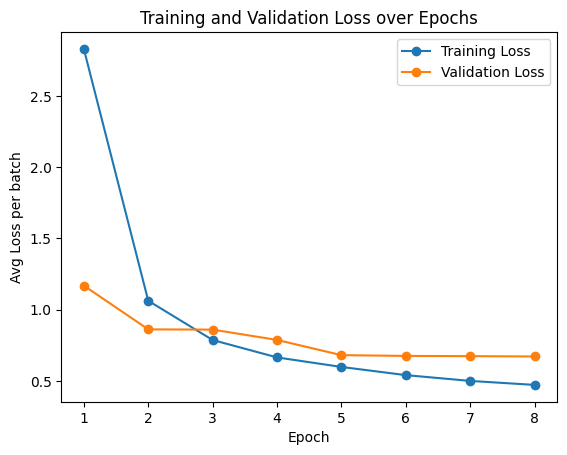

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')

plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Avg Loss per batch')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

Plotting pearson scores

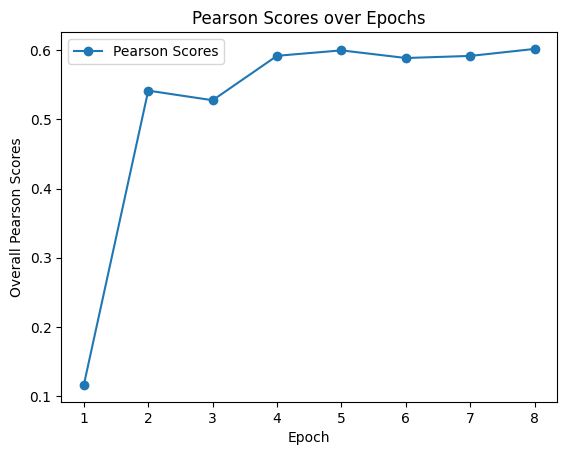

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.plot(range(1, num_epochs + 1), pearson_scores, marker='o', label='Pearson Scores')

# plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Overall Pearson Scores')
plt.title('Pearson Scores over Epochs')
plt.legend()
plt.show()

##Evaluation on test data

In [ ]:
def predict(model, data_loader):
  model.eval()
  overall_pred, overall_true = [], []
  with torch.no_grad():
    val_loss_sum=0
    for idx, (ids, att_msks, y) in enumerate(data_loader):
      ids, att_msks, y = ids.to(device), att_msks.to(device), y.to(device)
      y_pred = model(ids, att_msks)


      y_pred, y = torch.squeeze(y_pred).cpu().numpy().tolist(), torch.squeeze(y).cpu().numpy().tolist()
      overall_pred.append(y_pred)
      overall_true.append(y)

  return overall_pred, overall_true


In [ ]:
test_data = pd.read_csv('enriched_test_data.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283 entries, 0 to 1282
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1283 non-null   int64  
 1   pair_id     1283 non-null   object 
 2   lang1       1283 non-null   object 
 3   lang2       1283 non-null   object 
 4   text_1      1283 non-null   object 
 5   text_2      1283 non-null   object 
 6   Geography   1283 non-null   float64
 7   Entities    1283 non-null   float64
 8   Time        1283 non-null   float64
 9   Narrative   1283 non-null   float64
 10  Overall     1283 non-null   float64
 11  Style       1283 non-null   float64
 12  Tone        1283 non-null   float64
dtypes: float64(7), int64(1), object(5)
memory usage: 130.4+ KB


In [ ]:

test_data_loader = get_data_loader(filtered_test_df,False)

model.load_state_dict(torch.load("XLM_Roberta.pth"), strict=False)
model.to(device)
test_pred_overall, test_true_overall = predict(model, test_data_loader)
print(test_pred_overall)


<ipython-input-39-9f27b45f41a7>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("XLM_Roberta.pth"), strict=False)


[[2.041264057159424, 2.7355520725250244, 1.7473031282424927, 2.803884983062744, 2.7649574279785156, 1.7251644134521484, 1.7926521301269531], [1.6893362998962402, 2.325747489929199, 1.5887640714645386, 2.410653591156006, 2.3460142612457275, 1.559866189956665, 1.5974578857421875], [1.0564645528793335, 1.5459065437316895, 1.2265130281448364, 1.6306380033493042, 1.5202105045318604, 1.215602159500122, 1.1898659467697144], [0.907501757144928, 1.3569262027740479, 1.1242679357528687, 1.4373810291290283, 1.3159022331237793, 1.1198629140853882, 1.0780792236328125], [2.8655476570129395, 3.6222782135009766, 2.0399601459503174, 3.6374521255493164, 3.648770570755005, 2.0761704444885254, 2.2007932662963867], [1.0928817987442017, 1.5898668766021729, 1.2508331537246704, 1.6743947267532349, 1.5683568716049194, 1.24277663230896, 1.215840458869934], [1.7118827104568481, 2.35494065284729, 1.5978620052337646, 2.43519926071167, 2.3731696605682373, 1.5643041133880615, 1.6084388494491577], [1.2428449392318726,

In [ ]:
pearson_correlations = calculate_pearson_per_aspect(test_pred_overall, test_true_overall)
for i, r in enumerate(pearson_correlations):
        print(f"Pearson correlation for aspect {i+1}: {r:.4f}")

curr_pearson = np.mean(pearson_correlations)
print(f"Mean Pearson correlation for test dataset: {curr_pearson:.4f}")

Pearson correlation for aspect 1: 0.6416
Pearson correlation for aspect 2: 0.7806
Pearson correlation for aspect 3: 0.2769
Pearson correlation for aspect 4: 0.7458
Pearson correlation for aspect 5: 0.7811
Pearson correlation for aspect 6: 0.3744
Pearson correlation for aspect 7: 0.4377
Mean Pearson correlation for test dataset: 0.5769


In [ ]:
test_pred_overall

[[2.2306251525878906,
  2.9499990940093994,
  1.82440185546875,
  3.0067038536071777,
  2.980332612991333,
  1.8047449588775635,
  1.8902314901351929],
 [1.5965267419815063,
  2.211801528930664,
  1.5405962467193604,
  2.2995975017547607,
  2.2281486988067627,
  1.5126664638519287,
  1.5419503450393677],
 [1.0169219970703125,
  1.4947654008865356,
  1.1989084482192993,
  1.578224539756775,
  1.4654580354690552,
  1.190210223197937,
  1.1603955030441284],
 [0.8191719651222229,
  1.240829586982727,
  1.0581705570220947,
  1.3190324306488037,
  1.191035270690918,
  1.05914306640625,
  1.0083081722259521],
 [3.1814045906066895,
  3.931107521057129,
  2.1222240924835205,
  3.9198157787323,
  3.9450290203094482,
  2.2057547569274902,
  2.3431200981140137],
 [1.7354282140731812,
  2.3758480548858643,
  1.6087307929992676,
  2.4576053619384766,
  2.397005319595337,
  1.5880590677261353,
  1.6245568990707397],
 [1.6785346269607544,
  2.3133153915405273,
  1.5795767307281494,
  2.394692182540893